In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
%matplotlib inline
import torch
from deepseries.models import WaveNet
from deepseries.dataset import Property, TimeSeries, SeriesFrame
from deepseries.train import Learner
from torch.optim import Adam
from torch import nn
import matplotlib as mpl

In [2]:
power = pd.read_csv('./data/power.csv', parse_dates=['data_time'])[['data_time', 'cid', 'value']]
power = power.set_index("data_time").groupby("cid").resample("1H").sum().reset_index()
power = power.pivot(index='cid', columns='data_time', values='value')
power = power.apply(np.log1p)

In [3]:
# for cid in power.index:
#     plt.figure(figsize=(15, 3))
#     plt.plot(power.loc[cid])

In [4]:
is_zero = power.values == 0
is_nan = power.isnull().values
is_valid = ~is_zero & ~is_nan

xy = np.ma.masked_array(power.values, mask=~is_valid)

series_mu = xy.mean(axis=1).data.reshape(-1, 1)
series_std = xy.std(axis=1).data.reshape(-1, 1)
xy = (xy - series_mu) / series_std
xy = xy.filled(0.)

xy = np.expand_dims(xy, 1).astype('float32')

N_TEST = 24 * 30
DROP_ZERO = True
DEC_LEN = 24 * 2
ENC_LEN = 24 * 7
time_free_space = 24

In [36]:
xy.shape

(21, 1, 15792)

In [37]:
is_zero.shape

(21, 15792)

In [5]:
def periodic_feature(x, T):
    psin = np.sin(x * np.pi * 2 / T)
    pcos = np.cos(x * np.pi * 2 / T)
    return np.stack([psin, pcos], axis=0)

class ForwardSpliter:
    
    def split(self, time_idx, enc_len, dec_len, valid_size):
        if valid_size < 1:
            valid_size = int(np.floor(len(time_idx) * valid_size))
        valid_idx = time_idx[-(valid_size+enc_len):]
        train_idx = time_idx[:-valid_size]
        return train_idx, valid_idx
    
spliter = ForwardSpliter()
train_idx, valid_idx = spliter.split(np.arange(xy.shape[2]), ENC_LEN, DEC_LEN, 24 * 4)
valid_idx, test_idx = spliter.split(valid_idx, ENC_LEN, DEC_LEN, 24*2)

train_xy = TimeSeries(xy[:, :, train_idx])
valid_xy = TimeSeries(xy[:, :, valid_idx])

train_frame = SeriesFrame(train_xy, batch_size=4, enc_lens=ENC_LEN, dec_lens=DEC_LEN)
valid_frame = SeriesFrame(valid_xy, batch_size=4, enc_lens=ENC_LEN, dec_lens=DEC_LEN)

In [6]:
model = WaveNet()
opt = Adam(model.parameters(), 0.001)
loss_fn = nn.MSELoss()
learner = Learner(model, opt, loss_fn, '.', log_interval=20)
learner.fit(500, train_frame, valid_frame, patient=100)

epoch: 0 / 500 finished, valid loss 0.6339
epoch: 1 / 500 finished, valid loss 0.6481
epoch: 2 / 500 finished, valid loss 0.6755
epoch: 3 / 500, batch: 80%, train loss 0.2893
epoch: 3 / 500 finished, valid loss 0.6331
epoch: 4 / 500 finished, valid loss 0.5108
epoch: 5 / 500 finished, valid loss 0.6830
epoch: 6 / 500 finished, valid loss 0.6416
epoch: 7 / 500, batch: 80%, train loss 0.2189
epoch: 7 / 500 finished, valid loss 0.6604
epoch: 8 / 500 finished, valid loss 0.6517
epoch: 9 / 500 finished, valid loss 0.6503
epoch: 10 / 500 finished, valid loss 0.5989
epoch: 11 / 500, batch: 80%, train loss 0.1594
epoch: 11 / 500 finished, valid loss 0.5977
epoch: 12 / 500 finished, valid loss 0.5205
epoch: 13 / 500 finished, valid loss 0.3912
epoch: 14 / 500 finished, valid loss 0.2779
epoch: 15 / 500, batch: 80%, train loss 0.1720
epoch: 15 / 500 finished, valid loss 0.2996
epoch: 16 / 500 finished, valid loss 0.2683
epoch: 17 / 500 finished, valid loss 0.2418
epoch: 18 / 500 finished, valid 

In [39]:
np.expm1(
    learner.model.predict(torch.as_tensor(xy[[0], :, -ENC_LEN-48:-48].astype('float32')), 48).detach().numpy() * series_std[0] + series_mu[0]
)

array([[[19421.22032898, 20334.94462695, 20369.75387494, 17487.73402536,
         16308.20903265, 13129.50941808, 11028.25256346, 11983.648507  ,
         19960.07717366, 25222.03860716, 26592.64400506, 26201.82390586,
         23154.24979303, 25250.41455641, 25252.67024144, 23490.70734145,
         19500.55719246, 14287.63029538, 12646.158838  , 15295.42144353,
         18393.23580003, 20066.26233723, 21473.39082207, 20366.46490169,
         19210.74465918, 18271.13501285, 16562.2737719 , 14432.11194381,
         13344.12850657, 11472.52157268, 10092.57053514, 10561.21443161,
         16169.76246903, 19422.14431055, 20430.22488209, 19893.96422732,
         17802.60470254, 19380.72499825, 20055.072932  , 18546.50523728,
         14774.06815917, 11357.41999525, 10922.14354525, 12537.77786097,
         14534.12866334, 15678.09983947, 16052.87026371, 14711.71440685]]])

In [41]:
20000 / 4 * 26

130000.0

In [33]:
np.expm1(xy[[0], :, -48:]* series_std[0] + series_mu[0])

array([[[11442.97917953, 11098.94256348,  9819.88007584,  9336.51006775,
          9106.62502077,  7282.71496243,  5490.87467496,  1954.34110075,
         21432.55831504, 22189.1578403 , 21861.62552735, 20418.77217328,
         18847.10835569, 21063.56203739, 21340.39120316, 19757.35282973,
         16258.10491643, 13544.63877707, 13716.89747816, 15337.71561355,
         18534.8893034 , 18000.52991429, 13498.56689764, 17305.76099216,
         16896.87164152, 17314.70754194, 16825.43488691, 14738.83722967,
         14411.75797119, 12670.53063714, 11715.88155159, 12268.80888266,
         21336.79571512, 22181.23173179, 22120.18255075, 20781.71180214,
         19531.97229779, 22301.6881666 , 21556.24814848, 19881.45757305,
         17511.09794328, 14512.60148763, 14496.47615261, 16169.32704731,
         19262.64696048, 18323.91872354, 16792.99578288, 17937.74024553]]])

In [40]:
power

data_time,2018-05-24 00:00:00,2018-05-24 01:00:00,2018-05-24 02:00:00,2018-05-24 03:00:00,2018-05-24 04:00:00,2018-05-24 05:00:00,2018-05-24 06:00:00,2018-05-24 07:00:00,2018-05-24 08:00:00,2018-05-24 09:00:00,...,2020-03-11 14:00:00,2020-03-11 15:00:00,2020-03-11 16:00:00,2020-03-11 17:00:00,2020-03-11 18:00:00,2020-03-11 19:00:00,2020-03-11 20:00:00,2020-03-11 21:00:00,2020-03-11 22:00:00,2020-03-11 23:00:00
cid,,,,,,,,,,,,,,,,,,,,,
91E0B6DC00B91783E0530BC8100A0E30,9.496825,9.445136,9.434228,9.408299,9.332829,9.247694,9.175113,9.378845,9.722279,9.751261,...,9.978467,9.897593,9.770647,9.582842,9.581730,9.690933,9.865975,9.816017,9.728777,9.794718
91E0B6DC00BC1783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.754167,8.501483,9.926840,10.110278,10.063578,10.065684,10.043897,10.014930,9.992933,10.016579
91E0B6DC00C91783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.038288,8.099151,8.132775,8.255885,8.419299,8.422411,8.294524,8.161222,7.494934,7.325040
91E0B6DC00CB1783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.815780,8.807788,8.867837,8.863520,8.870413,8.838758,8.713577,7.921856,7.457766,7.243379
91E0B6DC00DA1783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.607157,8.627015,8.612302,8.623371,8.576914,8.494863,8.308109,7.622259,7.226458,7.000149
91E0B6DC00E31783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.888982,9.884770,9.885440,9.852730,9.830014,9.777006,9.821862,9.838426,9.842398,9.837599
91E0B6DC00E91783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91E0B6DC01081783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.557334,10.564848,10.564756,10.574970,10.565325,10.561247,10.568918,10.563400,10.552584,10.532464
91E0B6DC01171783E0530BC8100A0E30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.763531,10.800831,10.821937,10.918337,10.856743,10.862082,10.799878,10.810045,10.930490,10.839422


In [26]:
sub = np.expm1(power.iloc[0]).reset_index()

In [29]:
sub.groupby(sub.data_time.dt.date)['91E0B6DC00B91783E0530BC8100A0E30'].sum().iloc[-14:]

data_time
2020-02-27    455794.168788
2020-02-28    439177.624394
2020-02-29    447119.166288
2020-03-01    378332.535417
2020-03-02    400883.285720
2020-03-03         0.000000
2020-03-04    431751.226457
2020-03-05    430246.928939
2020-03-06    448324.308750
2020-03-07    432577.149356
2020-03-08    427035.265985
2020-03-09    375033.564318
2020-03-10    358640.499583
2020-03-11    421540.922242
Name: 91E0B6DC00B91783E0530BC8100A0E30, dtype: float64

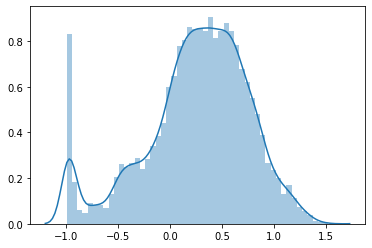

In [22]:
sns.distplot(np.expm1(xy[0]))

In [23]:
np.expm1(xy[0])

array([[0.10841969, 0.03689354, 0.02239933, ..., 0.6733998 , 0.4952184 ,
        0.6280296 ]], dtype=float32)